# 第5回演習課題

MNISTデータの読み込み

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

In [30]:
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [31]:
mnist = fetch_mldata('MNIST original')
mnist_x, mnist_y = mnist.data.astype("float32")/255.0, mnist.target.astype("int32")

train_X, test_X, train_y, test_y = train_test_split(mnist_x, mnist_y, test_size=0.2)

## 課題1：Denoising auto-encoderの実装．また，MNISTを用いて次のことを確認．
* reconstruction errorが小さくなっている（学習が進んでいる）．
* 重みの可視化（特徴の可視化）．

In [23]:
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from collections import OrderedDict

In [24]:
rng = np.random.RandomState(1234)
theano_rng = RandomStreams(rng.randint(1234))

In [25]:
def sgd(params,gparams,lr=0.1):
    updates = OrderedDict()
    for param, gparam in zip(params, gparams):
        updates[param] = param - lr * gparam
    return updates

Autoencoderクラス

In [105]:
class Autoencoder:
    def __init__(self,visible_dim,hidden_dim,function):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.function = function
        
        self.W = theano.shared(rng.uniform(
                    low=-4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    high=4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    size=(visible_dim,hidden_dim)
                ).astype("float32"),name="W")
        
        self.a = theano.shared(np.zeros(visible_dim).astype(np.float32),name="a")
        self.b = theano.shared(np.zeros(hidden_dim).astype(np.float32),name="b")
        self.params = [self.W,self.a,self.b]
        
    #encoder
    def encode(self,x):
        u = T.dot(x, self.W)+self.b
        y = self.function(u)
        return y
    
    #decoder
    def decode(self,x):
        u = T.dot(x, self.W.T)+self.a
        y = self.function(u)
        return y
    
    #forward propagation
    def prop(self,x):
        y = self.encode(x)
        reconst_x = self.decode(y)
        return reconst_x
    
    #reconstruction error
    def reconst_error(self,x,noise):
        tilde_x = x*noise
        reconst_x = self.prop(tilde_x)
        error = T.mean(T.sum(T.nnet.binary_crossentropy(reconst_x,x),axis=1))
        return error, reconst_x

In [108]:
model = Autoencoder(train_X.shape[1],300,T.nnet.sigmoid)

x = T.matrix('x')
noise = T.matrix('noise')

cost,reconst_x = model.reconst_error(x,noise)
params  = model.params
gparams = T.grad(cost, params)
updates = sgd(params,gparams) 

train = theano.function([x,noise], [cost,reconst_x], updates=updates, allow_input_downcast=True)

In [109]:
corruption_level = 0.0 ###noise
batch_size = 100
nbatches = train_X.shape[0] // batch_size

for epoch in range(2):
    train_X = shuffle(train_X)
    err_all=[]
    for i in range(0,nbatches):
        start = i * batch_size
        end   = start + batch_size
        
        noise = rng.binomial(size=train_X[start:end].shape, n=1, p=1-corruption_level)
        err,reconst_x = train(train_X[start:end],noise)
        err_all.append(err)
    print "Epoch:%d, Error:%lf" %(epoch, np.mean(err_all))

Epoch:0, Error:85.237694
Epoch:1, Error:68.214050


重みの可視化
* corruption_levelを変更して違いを観測

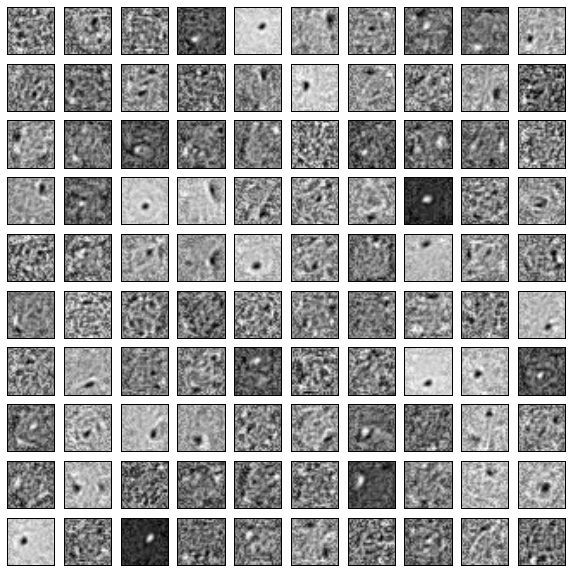

In [10]:
weight = model.W.get_value(borrow=True).T

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight[i].reshape((28,28)), cmap='gray')

## 課題2：RBMの実装．また，MNISTを用いて次のことを確認．
* reconstruction errorが小さくなっている（学習が進んでいる）．
* 重みの可視化（特徴の可視化）．
* 文字の生成

In [28]:
rng = np.random.RandomState(1234)
theano_rng = RandomStreams(rng.randint(1234))

RBMクラスの実装

In [ ]:
class RBM:
    def __init__(self,visible_dim,hidden_dim,function,k):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.function = function
        self.k = k
        
        self.W = theano.shared(rng.uniform(
                    low=-4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    high=4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    size=(visible_dim,hidden_dim)
                ).astype("float32"),name="W")
        self.a = theano.shared(np.zeros(visible_dim).astype("float32"),name="a")
        self.b = theano.shared(np.zeros(hidden_dim).astype("float32"),name="b")
        
        self.params = [self.W,self.a,self.b]
        
    def propup(self,input):
        y = T.dot(input,self.W) + self.b
        output = self.function(y)
        return output
    
    def propdown(self,input):
        y = T.dot(input,self.W.T) + self.a
        output = self.function(y)
        return output

    #p(h|v)
    def ph_v(self,v):
        h = self.propup(v)
        h_sample = theano_rng.binomial(size=h.shape,n=1, p=h, dtype="float32")
        return h_sample,h
    
    #p(v|h)
    def pv_h(self,h):
        v = self.propdown(h)
        v_sample = theano_rng.binomial(size=v.shape,n=1, p=v, dtype="float32")
        return v_sample,v
    
    #gibbs sampling(h→v→h)
    def gibbs_hvh(self,h):
        v_sample,mean_v = self.pv_h(h)
        h_sample,mean_h = self.ph_v(v_sample)
        return h_sample,mean_h
        
    #gibbs sampling(v→h→v)
    def gibbs_vhv(self,v):
        h_sample,mean_h = self.ph_v(v)
        v_sample,mean_v = self.pv_h(h_sample)
        return v_sample,mean_v
    
    #cost(free energy)
    def free_energy(self,input):
        y = T.dot(input,self.W) + self.b
        return -T.dot(input,self.a) -T.sum(T.log(1 + T.exp(y)),axis=1)
    
    #reconstruction error
    def reconst_error(self,v):
        v_sample = v
        for k in range(self.k):
            v_sample,mean_v = model.gibbs_vhv(v_sample)
            
        cross_entropy = T.mean(T.sum(T.nnet.binary_crossentropy(mean_v,v),axis=1))
        return cross_entropy

In [ ]:
x = T.matrix("x")
persistent = T.matrix("persistent")

#K(the number of gibbs sampling)
K = 1
model = RBM(train_X.shape[1],500,T.nnet.sigmoid,K)

#persistent RBM
_x = persistent
for k in range(K):
    _x,_  = model.gibbs_vhv(_x)

cost    = T.mean(model.free_energy(x)) -T.mean(model.free_energy(_x))
params  = model.params
gparams = T.grad(cost, params, consider_constant=[_x])
updates = sgd(params, gparams) 
err     = model.reconst_error(x)

train = theano.function([x,persistent], [cost,_x], updates=updates, allow_input_downcast=True)
reconst = theano.function([x], err, allow_input_downcast=True)

In [ ]:
batch_size = 100
nbatches = train_X.shape[0] // batch_size

persistent = train_X.copy()
for epoch in range(10):
    train_X,persistent = shuffle(train_X,persistent)
    err_all=[]
    for i in range(0,nbatches):
        start = i * batch_size
        end   = start + batch_size
        
        cost,_x = train(train_X[start:end],persistent[start:end])
        persistent[start:end]=_x
        err = reconst(train_X[start:end])
        err_all.append(err)
    print "Epoch:%d, Error:%lf" %(epoch, np.mean(err))

重みの可視化

In [ ]:
weight = model.W.get_value(borrow=True).T

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight[i].reshape((28,28)), cmap='gray')

データの生成

In [ ]:
#gibbs sampling
v = T.matrix("v")
[sample_v,mean_v],updates = theano.scan(fn=model.gibbs_vhv,outputs_info=[v,None],n_steps=1000)
sample = theano.function([v], [sample_v[-1],mean_v[-1]],updates=updates,allow_input_downcast=True)


#reconstructionしたxを使う
#seed
test_X = shuffle(test_X)
sample_v,mean_v = sample(test_X[0:100])

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(mean_v[i].reshape((28,28)), cmap='gray')

## Stacked auto-encoderの実装

In [26]:
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from collections import OrderedDict
rng = np.random.RandomState(1234)

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist_x, mnist_y = mnist.data.astype("float32")/255.0, mnist.target.astype("int32")

以下のセルを完成させて提出

In [5]:
#Autoencoder (or RBM)
class Autoencoder:
    def __init__(self,visible_dim,hidden_dim,W,function):
        ## WRITE ME
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.function = function
        self.W =W
        self.a = theano.shared(np.zeros(visible_dim).astype(np.float32),name="a")
        self.b = theano.shared(np.zeros(hidden_dim).astype(np.float32),name="b")
        self.params = [self.W,self.a,self.b]

    #encoder
    def encode(self,x):
        ## WRITE ME
        u = T.dot(x, self.W)+self.b
        y = self.function(u)
        return y
        
    #decoder
    def decode(self,x):
        ## WRITE ME
        u = T.dot(x, self.W.T)+self.a
        y = self.function(u)
        return y
    
    #forward propagation
    def prop(self,x):
        ## WRITE ME
        y = self.encode(x)
        reconst_x = self.decode(y)
        return reconst_x
    
    #reconstruction error
    def reconst_error(self,x,noise):
        tilde_x = x*noise
        reconst_x = self.prop(tilde_x)
        error = T.mean(T.sum(T.nnet.binary_crossentropy(reconst_x,x),axis=1))
        return error, reconst_x
    
#SGD
def sgd(params,gparams,lr=0.1):
    updates = OrderedDict()
    for param, gparam in zip(params, gparams):
        updates[param] = param - lr * gparam
    return updates
  

In [80]:
  
#Multi Layer Perceptron
class Layer:
    def __init__(self, in_dim, out_dim, function):
        self.W = theano.shared(rng.uniform(low=-np.sqrt(6. / (in_dim + out_dim)),high =np.sqrt(6. / (in_dim + out_dim)),size =(in_dim,out_dim)).astype('float32'), name = 'W')
        self.b = theano.shared(np.zeros(out_dim).astype('float32'), name = 'bias')
        self.params = [ self.W, self.b]
        
        self.W1 = theano.shared(0*rng.uniform(low=-np.sqrt(6. / (in_dim + out_dim)),high =np.sqrt(6. / (in_dim + out_dim)),size =(in_dim,out_dim)).astype('float32'), name = 'W')
        self.b1 = theano.shared(np.zeros(out_dim).astype('float32'), name = 'bias')
        self.momentums = [ self.W1, self.b1]       
             
        self.function = function
        self.h = None
        self.in_dim = in_dim
        self.out_dim =out_dim


    def fprop(self, x):
        h=self.function(theano.tensor.dot(x,self.W)+self.b)
        self.h = h
        return h
    
    def set_pretraining(self):
        ae = Autoencoder(self.in_dim,self.out_dim,self.W,self.function)
        ###noise = T.matrix('noise')
        ###noise =rng.binomial(size=train_X[start:end].shape, n=1, p=1-corruption_level)
        ##start = i*batch_size
        ##end = (i+1)*batch_size
        self.params[0] =ae.params[0]
        x  = T.matrix('X')
        noise = T.matrix('noise')
        ###noise =rng.binomial(size=x.shape, n=1, p=1-corruption_level)
        cost,reconst_x = ae.reconst_error(x,noise)
        params  = ae.params
        gparams = T.grad(cost, params)
        updates = sgd(params,gparams)
        self.pretraining = theano.function([x,noise], [cost,reconst_x], updates=updates, allow_input_downcast=True)
        hidden = ae.encode(x)
        self.encode_function = theano.function([x], hidden, allow_input_downcast=True)

train_X, valid_X, train_y, valid_y = train_test_split(mnist_x, mnist_y, test_size=0.2, random_state=42)

In [81]:
layers = [Layer(784,300,T.nnet.sigmoid),Layer(300,100, T.nnet.sigmoid),Layer(100,10, T.nnet.softmax)]

In [82]:
def sgd(params,gparams,lr=0.1):
    updates = OrderedDict()
    for param, gparam in zip(params, gparams):
        updates[param] = param - lr * gparam
    return updates

#Pre-training
X = train_X
for l, layer in enumerate(layers[:-1]):
    corruption_level = 0.2## WRITE ME
    batch_size = 100
    X = shuffle(X)
    nbatches = X.shape[0] // batch_size
    ###print X.shape
    ###print nbatches       
    layer.set_pretraining()
    for epoch in range(3):
        err_all = []           
        for i in range(nbatches):
            start = i*batch_size
            end = (i+1)*batch_size
            noise =rng.binomial(size=X[start:end].shape, n=1, p=1-corruption_level)
            err,recosnt = layer.pretraining(X[start:end],noise)
            err_all.append(err)
        print "Pre-training:: layer:%d, Epoch:%d, Error:%lf" %(l,epoch, np.mean(err_all))
    X = layer.encode_function(X)  

Pre-training:: layer:0, Epoch:0, Error:103.778679
Pre-training:: layer:0, Epoch:1, Error:79.379623
Pre-training:: layer:0, Epoch:2, Error:74.443741
Pre-training:: layer:1, Epoch:0, Error:122.803406
Pre-training:: layer:1, Epoch:1, Error:106.729126
Pre-training:: layer:1, Epoch:2, Error:103.904655


In [86]:
layers = [Layer(784,300,T.tanh),Layer(300,100, T.tanh),Layer(100,10, T.nnet.softmax)]

In [87]:

def sgd(params,momentums,gparams,lr=0.01):
    updates = OrderedDict()
    for param, momentum,gparam in zip(params,momentums,gparams):
        updates[momentum] = -lr*gparam + 0.4*momentum
        updates[param] = momentum + param
    return updates

#Fine-tuning
x, t = T.fmatrix("x"), T.ivector("t")
params = []
momentums = []
for i, layer in enumerate(layers):
    params += layer.params
    momentums += layer.momentums
    if i == 0:
        layer_out = layer.fprop(x)
    else:
        layer_out = layer.fprop(layer_out)

y = layers[-1].h
cost = - T.mean((T.log(y))[T.arange(y.shape[0]), t])

gparams = T.grad(cost, params)
updates = sgd(params,momentums,gparams)
####updates2 =sgd(params,gparams,lr=0.01)

train = theano.function([x,t], cost, updates=updates)
valid  = theano.function([x,t],[cost, T.argmax(y, axis=1)])
test  = theano.function([x],T.argmax(y, axis=1))

valid_cost=valid(valid_X,valid_y)[0]

In [91]:
batch_size = 50
answer =[]
nbatches = train_X.shape[0]//batch_size
for epoch in range(20):
    train_X, train_y = shuffle(train_X,train_y)
    for i in range(nbatches):
        start = i*batch_size
        end = (i+1)*batch_size
        train(train_X[start:end],train_y[start:end])
    valid_cost ,pre_y = valid(valid_X,valid_y)
    print valid_cost
    answer.append(pre_y)
    ##print "EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f"%(epoch+1, valid_cost, f1_score(valid_y, pred, average="macro"))



0.0751555263996
0.0738257244229
0.07364782691
0.0732896402478
0.0734899267554
0.0735609829426
0.0743895694613
0.0740849673748
0.0736655816436
0.0734897106886
0.0729999244213
0.0734530463815
0.0730772763491
0.0738618597388
0.0744978263974
0.0736276656389
0.0735923722386
0.0736422911286
0.0735855922103
0.0734330266714


In [92]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
####print len(answer)
print classification_report(answer[19],valid_y)
####print precision_score(answer[30],valid_y)

             precision    recall  f1-score   support

          0       0.98      0.98      0.98      1351
          1       0.99      0.99      0.99      1579
          2       0.98      0.98      0.98      1404
          3       0.97      0.98      0.98      1429
          4       0.98      0.98      0.98      1331
          5       0.97      0.97      0.97      1282
          6       0.99      0.98      0.98      1413
          7       0.98      0.98      0.98      1474
          8       0.98      0.97      0.97      1404
          9       0.96      0.98      0.97      1333

avg / total       0.98      0.98      0.98     14000



In [64]:
#Multi Layer Perceptron
import numpy as np
srng = theano.tensor.shared_randomstreams.RandomStreams(
            rng.randint(999999))
class Layer:
    def __init__(self, in_dim, out_dim, function):
        self.W = theano.shared(rng.uniform(low=-np.sqrt(6. / (in_dim + out_dim)),high = np.sqrt(6. / (in_dim + out_dim)),size =(in_dim,out_dim)).astype('float32'), name = 'W')
        self.b = theano.shared(np.zeros(out_dim).astype('float32'), name = 'bias')
        self.params = [ self.W, self.b]
        self.func = function
        self.h = None

    def fprop(self,x):
        h = self.func(theano.tensor.dot(x,self.W)+self.b)
        ###h = theano.tensor.dot(x,self.W)+self.b
        self.h = h
        return h
    def dfrop(self,x,p):
        mask = srng.binomial(n=1, p=1-p, size=x.shape).astype('float32')
        h2 = self.func(theano.tensor.dot(x*mask,self.W)+self.b)
        ###h = theano.tensor.dot(x,self.W)+self.b
        self.h2 = h2
        return h2       
class Dropout():
    def __init__(self, p):
        self.p = p
        self.params = []

    def fprop(self, x, use_noise=True):
        #####
        pass

x, t = T.fmatrix("x"), T.ivector("t")
activation = T.nnet.sigmoid #T.tanh こっちのようがよい　learning rate 変えてみる　


layers = [
    Layer(in_dim =784, out_dim=300, function = T.tanh),
    Layer(in_dim =300, out_dim=100,function = T.tanh),
    Layer(in_dim =100, out_dim = 10, function = T.nnet.softmax)
    ]

####print layers[2].W.get_value().shape

## Collect Parameters and Symbolic output
params = []
i=0
for layer in layers:
    params += layer.params
    if i == 0:
        layer_out2 = layer.dfrop(x,0.0)
        layer_out = layer.fprop(x)*(1-0.0)
    else:
        layer_out2 = layer.dfrop(layer_out2,0.0)
        layer_out = layer.fprop(layer_out)*(1-0.0)
    i=1
        
## Cost Function (Negative Log Likelihood)
y2 = layers[-1].h2
cost2 = -T.mean(T.log(y2)[T.arange(y2.shape[0]),t])
## Get Gradient
y = layers[-1].h2
cost = -T.mean(T.log(y)[T.arange(y.shape[0]),t])
lr = np.float32(0.1)

gparams = T.grad(cost2,params)
updates = OrderedDict()

lrlr = T.fscalar('lrlr')
momentum2 = T.fscalar('momentum2')
## Defile Learning Rule, you can add Adagrad, Adadelta etc.
lr, momentum = np.float32(0.1), np.float32(0.01)
iii=0
for param, gparam in zip(params, gparams):
    if iii==0:
        hey = param
        momentum = np.float32(0.0)
    else:
        momentum = np.float32(1.0)
    updates[param] = param -lrlr*gparam+ momentum*momentum2*hey
    hey = gparam  


## Compile 
train = theano.function([x,t,lrlr,momentum2],[cost2,y], updates=updates)
test = theano.function([x,t],[cost, T.argmax(y, axis=1)])

## Iterate
batch_size = 50
nbatches = train_X.shape[0]/batch_size
print train_X.shape[0]
answer=[]
for epoch in range(60):
    if epoch<40:
        train_X, train_y = shuffle(train_X,train_y)
        for i in range(nbatches):
            start = i*batch_size
            end = start + batch_size
            train(train_X[start:end],train_y[start:end],0.1,0.05)

        valid_cost,pred = test(valid_X,valid_y )
    else:
        train_X, train_y = shuffle(train_X,train_y)
        for i in range(nbatches):
            start = i*batch_size
            end = start + batch_size
            train(train_X[start:end],train_y[start:end],0.01,0.05)

        valid_cost,pred = test(valid_X,valid_y )        
    
    ###if epoch+1 % 10 ==0:
        ###print "cost".format(epoch+1.valid_cost,f1_score(valid_y,pred))
    answer.append(pred)
    print valid_cost



56000
0.200013667345
0.157994240522
0.132806241512
0.118680350482
0.0974019318819
0.0891194716096
0.0851173475385
0.0783546343446
0.0781912431121
0.076824106276
0.07553781569
0.0758808478713
0.0746819600463
0.0739231556654
0.0736272856593
0.0732160061598
0.0720751211047
0.0724562332034
0.0704272687435
0.0718164145947
0.0729365646839
0.0720899775624
0.07236263901
0.0719348341227
0.0722866281867
0.0732608810067
0.0729931890965
0.0730169042945
0.0737841725349
0.0731126889586
0.0735253766179
0.0740147158504
0.0746804922819
0.074247635901
0.0752969458699
0.0747015327215
0.0751969069242
0.0750378444791
0.0753661170602
0.0756926089525
0.07568590343
0.075701855123
0.0756322219968
0.0757153704762
0.0757007598877
0.0756969973445
0.0757869780064
0.0757604911923
0.0757741108537
0.0758315101266
0.0758436471224
0.075840651989
0.0758755207062
0.0758300274611
0.0759171471
0.0759202763438
0.0759365558624
0.075981579721
0.0759952291846
0.0759903565049
